In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
import os
# import pytorch_lightning as pl
# local import
import torch.nn as nn
from torch import optim
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import matplotlib.animation as animation


class CSPUpBlock(nn.Module):
    def __init__(self, in_channels):
        super(CSPUpBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=2, stride=2)
        self.upsample1 = nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv3_1 = nn.Conv2d(in_channels//2, in_channels//2, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels//2, in_channels//2, kernel_size=3, padding=1)

    def forward(self, x):
        # 1 way
        conv0_x = self.conv1(x)
        upsampled_x = self.upsample(conv0_x)

        # 2 way
        conv1_x = self.conv1(x)
        relu_x = self.relu(conv1_x)
        upsampled_conv1_x = self.upsample1(relu_x)
        conv3_x1 = self.conv3_1(upsampled_conv1_x)
        relu_conv3_x1 = self.relu(conv3_x1)
        conv3_x2 = self.conv3_2(relu_conv3_x1)

        # merge
        out = upsampled_x + conv3_x2

        return out


class Encoder(nn.Module):
    def __init__(self, in_channels=1024):
        super(Encoder, self).__init__()
        
        self.norm = nn.ConvTranspose2d( 100, in_channels, 4, 1, 0, bias=False)
        self.csp_up_block1 = CSPUpBlock(in_channels=in_channels)
        self.csp_up_block2 = CSPUpBlock(in_channels=in_channels//2)
        self.csp_up_block3 = CSPUpBlock(in_channels=in_channels//4)
        self.csp_up_block4 = CSPUpBlock(in_channels=in_channels//8)

        self.deconv2d = nn.ConvTranspose2d(in_channels//16, 3, kernel_size=2, stride=2)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.norm(x)
        x = self.csp_up_block1(x)
        x = self.csp_up_block2(x)
        x = self.csp_up_block3(x)
        x = self.csp_up_block4(x)
        x = self.deconv2d(x)
        y = self.relu(x)
        return y

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)
        self.conv6 = nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0)

        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.conv6(x)  # Flatten for binary classification
        x = self.sigmoid(x)
        return x



In [88]:
# Количество воркеров для сборки датасета
workers = 16

# Размер батча
batch_size = 128*2

# Размер входа сети для изображений. Все изображения ресайзятся к нему
image_size = 128

# Количество каналов цвета
nc = 3

# Размер латентного вектора (размерность латентного пространства)
nz = 100

# Size of feature maps in generator
ngf = 64

# Рамер карты признаков для генератора
ndf = 64

# Кол-во эпох
num_epochs = 5

# Лернингрейт
# lr_g = 0.00005
# lr_d = 0.00005

lr_g = 0.00008
lr_d = 0.00008

# Параметр для оптимизатора Adam
beta1 = 0.5

# Количество GPU, 0 если считаем на CPU
ngpu = 1

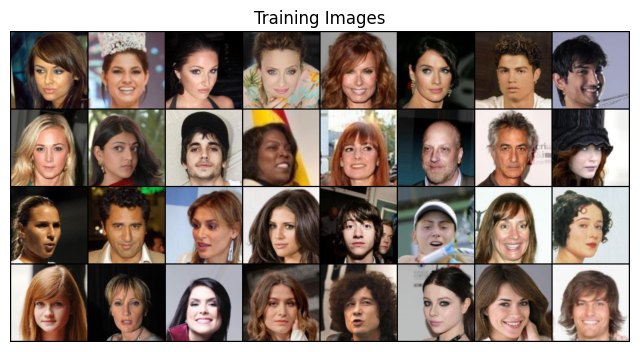

In [89]:

transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               # transforms.Lambda(lambda x: x.repeat(3,1,1)),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

dataroot = os.path.abspath(os.path.join("dataset/celeba"))

dataset = datasets.ImageFolder(root=dataroot,
                           transform=transform)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


# Нарисуем часть картинок из датасета
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [90]:
# Create the generator
netG = Encoder(in_channels=1024).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.


# Print the model
print(netG)

Encoder(
  (norm): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (csp_up_block1): CSPUpBlock(
    (upsample): ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
    (upsample1): ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
    (conv1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (csp_up_block2): CSPUpBlock(
    (upsample): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
    (upsample1): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
    (conv1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (co

In [91]:
# инициализируем дискриминатор
netD = Discriminator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))


print(netD)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (sigmoid): Sigmoid()
)


In [92]:
# Инициализируем лосс
criterion = nn.BCELoss()

# Создаем батч с рандомным шумом для генерации
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Метки для реальных данных и фековых
real_label = 1.
fake_label = 0.

# Устанавливаем оптимизаторы для G и D
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

In [93]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# Для каждой эпохи
for epoch in range(num_epochs):
    # Для каждого батча
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Учим дискриминатор: максимизируем log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Для батча
        real_cpu = data[0].to(device)
        
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Прямой прогон батча из реальных картинок D
        output = netD(real_cpu).view(-1)
        # Считаем лосс на всем батче реальных картинок
        # print(output.shape,label.shape)
        errD_real = criterion(output, label)
        # Вычисляем градиенты для дискриминатора
        errD_real.backward()
        D_x = output.mean().item()

        ## Учим на полном фейковом батче
        # Генерируем бат латентных векторов
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Генерируем фековый батч с помощью G
        fake = netG(noise)
        label.fill_(fake_label)
        # Классифицируем фековый батч с помощью D
        output = netD(fake.detach()).view(-1)
        # Вычисляем лосс дискриминатора на фейковом батче
        errD_fake = criterion(output, label)
        # Вычисляем градиент для фейкового батча, он суммируется с предидущим
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Вычисляем ошибку на реальном и фековом батчах
        errD = errD_real + errD_fake
        # Обновляем веса D
        optimizerD.step()

        ############################
        # (2) Учим генератор: максимизируем log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # для генератора фейковые метки есть реальные (0 меняем на 1)
        # Так как мы обновили веса дискриминатора прогоним фековый батч через него еще  раз
        output = netD(fake).view(-1)
        # Вычислим лосс G основываясь на выходе D
        errG = criterion(output, label)
        # Вычислим градиент для G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Обновляем веса G
        optimizerG.step()

        # Выводим статистику обучения
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Сохраним лоссы
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Проверим какие картинки рисует генератор
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/792]	Loss_D: 1.3873	Loss_G: 0.6908	D(x): 0.4998	D(G(z)): 0.5003 / 0.5012
[0/5][50/792]	Loss_D: 0.1382	Loss_G: 5.6532	D(x): 0.9502	D(G(z)): 0.0662 / 0.0035
[0/5][100/792]	Loss_D: 0.6756	Loss_G: 1.5896	D(x): 0.8100	D(G(z)): 0.3470 / 0.2065
[0/5][150/792]	Loss_D: 0.7888	Loss_G: 1.7600	D(x): 0.6988	D(G(z)): 0.2267 / 0.1829
[0/5][200/792]	Loss_D: 0.6034	Loss_G: 2.6169	D(x): 0.8066	D(G(z)): 0.2591 / 0.0865
[0/5][250/792]	Loss_D: 0.5091	Loss_G: 2.4722	D(x): 0.8270	D(G(z)): 0.2008 / 0.0955
[0/5][300/792]	Loss_D: 0.6681	Loss_G: 2.1157	D(x): 0.7469	D(G(z)): 0.2234 / 0.1404
[0/5][350/792]	Loss_D: 0.9964	Loss_G: 1.3387	D(x): 0.5780	D(G(z)): 0.2676 / 0.2786
[0/5][400/792]	Loss_D: 1.2647	Loss_G: 1.7122	D(x): 0.5565	D(G(z)): 0.4258 / 0.1965
[0/5][450/792]	Loss_D: 0.9969	Loss_G: 1.3984	D(x): 0.6193	D(G(z)): 0.3291 / 0.2688
[0/5][500/792]	Loss_D: 0.9316	Loss_G: 1.1866	D(x): 0.6004	D(G(z)): 0.2700 / 0.3229
[0/5][550/792]	Loss_D: 0.8899	Loss_G: 2.1701	D(x): 0.7689	D(G(z)

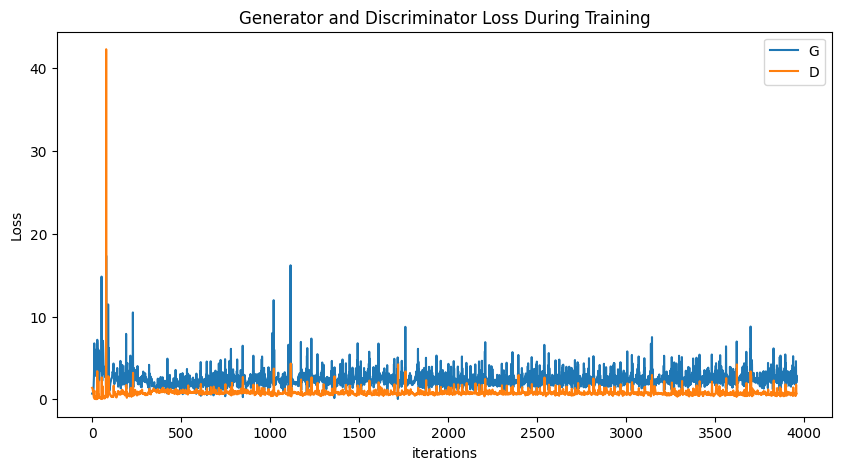

In [94]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

HTML(value='\n<link rel="stylesheet"\nhref="https://maxcdn.bootstrapcdn.com/font-awesome/4.4.0/css/font-awesom…

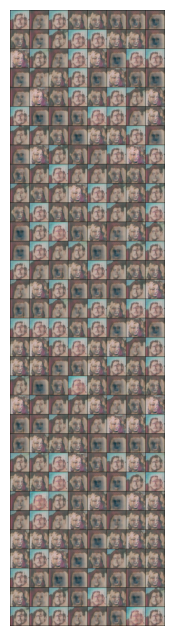

In [85]:
from ipywidgets import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

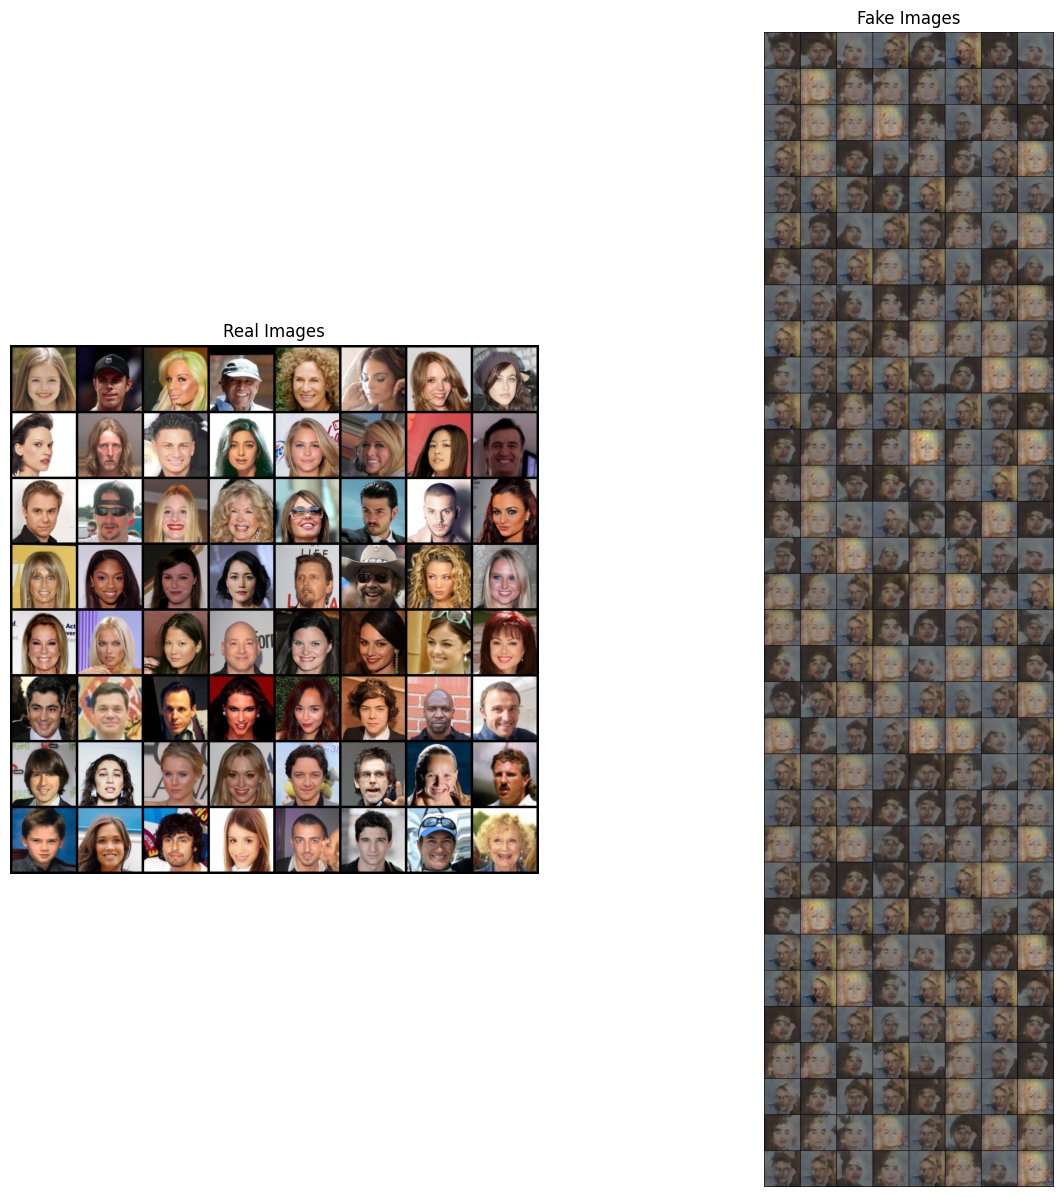

In [95]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
# plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

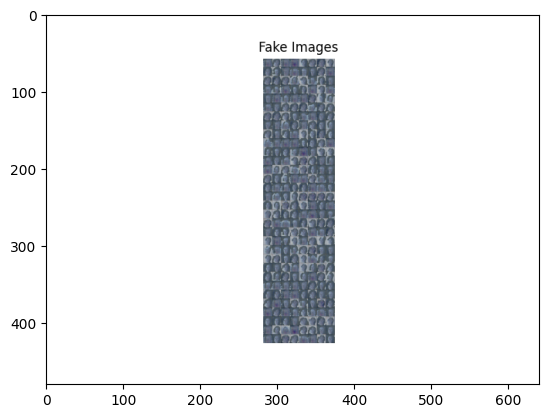

In [2]:
import cv2
from matplotlib import pyplot as plt 
img = cv2.imread("/media/storonkin/Work/projects/ml_course_deep_gan/deep_hw_2/myplot.png")
plt.imshow(img)
plt.show()